This notebook show the procedure of fitting a gaussian distribution with MCMC.

Given the mean $\mu$ and std $\sigma$, the likelihood of observing $x$ is 

$$ P\left(x|\mu,\sigma \right)= \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{\left(x-\mu\right)^2}{2\sigma^2} \right)$$


If you have many $x$s, simply multiply them. In practice, better use log form. The log of likelihood is 

$$ \log P\left(x|\mu,\sigma \right)= -0.5*\log\left(2\pi\right)-\log\left(\sigma\right)  -\frac{\left(x-\mu\right)^2}{2\sigma^2}  $$

$$ \log P\left(x|\mu,\sigma \right)= -0.5*\log\left(2\pi\right)+\log\left(i\sigma\right)  -\frac{\left(x-\mu\right)^2}{2}i\sigma^2  $$


In [2]:
mu=19
isigma=5

In [33]:
dataList=np.random.normal(mu,1./isigma,20)

In [34]:
dataList

array([18.95146209, 18.97602072, 18.90192622, 18.89504345, 19.0079191 ,
       19.06738845, 19.33114954, 18.76078305, 19.40113022, 18.80580225,
       18.72431966, 18.88020395, 19.09426091, 19.1333501 , 19.20722009,
       19.13907951, 19.19026397, 18.89746437, 18.96695321, 18.82437917])

In [35]:
mu0=1; #np.random.exponential(1)
isigma0=1; #np.random.exponential(1)

P0= np.sum( np.log(isigma0)-(dataList-mu0)**2/2.*isigma0**2  ) #log form 


muList=[mu0]
isigmaList=[isigma0]


for i in range(20000):
    muCand=muList[-1]+np.random.normal(0,2)
    isigmaCand=isigmaList[-1]+np.random.normal(0,1)
    
    if isigmaCand<0:
        continue
    
    P1= np.sum( np.log(isigmaCand)-(dataList-muCand)**2/2.*isigmaCand**2  ) #log form 

    
    u=np.random.uniform(0,1)
    #P1<P0
    #P1/P0
    #e(P1)/e(P0)>u
    if  P1>P0 or P1-P0 >np.log(u) :
        
        muList.append(muCand)
        isigmaList.append(isigmaCand)
        P0=P1
    else:
        ##
        muList.append(muList[-1])
        isigmaList.append(isigmaList[-1])

        
print "done"


done


In [36]:
len(muList)

19794

In [53]:

#muList[2000:]
import pymc3 as pm

low,up= pm.stats.hpd(np.array(muList[2000:]),alpha=0.1) #90% HPD

mean= np.mean(muList[2000:])
print mean
print mean-low

print up-mean
 



19.006688843709956
0.05564152348721407
0.06155145787920091


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([18.88553157, 18.89042392, 18.89531627, 18.90020862, 18.90510098,
        18.90999333, 18.91488568, 18.91977803, 18.92467039, 18.92956274,
        18.93445509, 18.93934744, 18.9442398 , 18.94913215, 18.9540245 ,
        18.95891685, 18.96380921, 18.96870156, 18.97359391, 18.97848626,
        18.98337862, 18.98827097, 18.99316332, 18.99805567, 19.00294802,
        19.00784038, 19.01273273, 19.01762508, 19.02251743, 19.02740979,
        19.03230214, 19.03719449, 19.04208684, 19.0469792 , 19.05187155,
        19.0567639 , 19.06165625, 19.06654861, 19.07144096, 19.07633331,
        19.08122566, 19.08611802, 19.09101037, 19.09590272, 19.10079507,
        19.10568742, 19.11057978, 19.11547213, 19.12036448, 19.12525683,
        19.13014919])

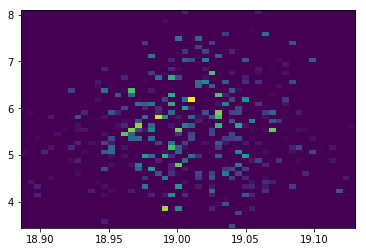

In [42]:
plt.hist2d(muList[1000:],isigmaList[1000:],bins=50)

In [92]:
#simulate gaussian data
np.random.seed()

mu_sim=20,
std_sim=5,
####### 
simData=np.random.normal(mu_sim,std_sim,2000)

In [93]:
#assmuing we do not inow mu_sim and std_sim.

def getlogp(data,mu,istd):
    logp=-0.5*np.log(2*np.pi)+0.5*np.log(istd**2)-(data-mu)**2/2.*istd**2
    
    return np.sum(logp)


In [94]:
getlogp(simData,1,3)

-3489500.91251559

In [127]:
#the MCMC part

mu0=np.random.exponential(2)
istd0=np.random.exponential(1)

P0=getlogp(simData,mu0,istd0)

muList= [mu0]
istdList=[ istd0]

for i in range(100000):
    muCand=muList[-1]+np.random.normal(0,0.5)
    istdCand=istdList[-1]+np.random.normal(0,0.5)
    
    if istdCand<0 : #we only want positive values
        continue
    
    P1=getlogp(simData,muCand,istdCand)
    
    u=np.random.uniform(0,1)

    if P1>P0 or P1-P0>np.log(u):
        #accept
        P0=P1
        #print muCand,1./istdCand,i
        muList.append(muCand)
        istdList.append(istdCand)
    else:
        #rect
        #continue
        muList.append(muList[-1])
        istdList.append(istdList[-1])
burn_in=3000
goodMu=np.array(muList[burn_in:])
goodstdList=1./np.array(istdList[burn_in:])

goodMu=goodMu[::5]
goodstdList=goodstdList[::5]


print len(goodMu)
print "Done"

12446
Done


In [105]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([   9.,    0.,  102.,   78.,  437.,  475., 1098.,  791., 1600.,
        1798., 1886., 1297.,  968.,  950.,  324.,  288.,  234.,   29.,
          27.,   55.]),
 array([4.83099595, 4.85602712, 4.88105829, 4.90608946, 4.93112063,
        4.9561518 , 4.98118297, 5.00621414, 5.03124531, 5.05627648,
        5.08130765, 5.10633882, 5.13136999, 5.15640116, 5.18143233,
        5.2064635 , 5.23149467, 5.25652584, 5.28155701, 5.30658818,
        5.33161935]),
 <a list of 20 Patch objects>)

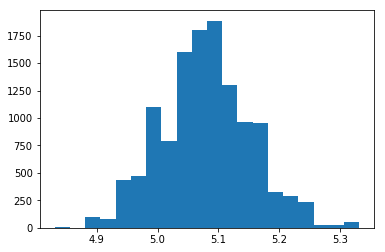

In [129]:
plt.hist(goodstdList,bins=20)